In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from utils.data_processing import get_df

In [26]:
# Load data
df = get_df()

# Logistic Model 
def logistic_model(delta_R, A, B, sigma):
    # A = Info Bonus, B = Spatial Bias, sigma = Decision Noise
    return 1 / (1 + np.exp(-(delta_R + A + B) / (np.sqrt(2) * sigma)))

# high info

In [ ]:
def get_high_info_stats(row):
    # 0 is the Equal condition [2, 2] 
    if row['uc'] == 0: 
        return pd.Series([np.nan, np.nan], index=['delta_R_info', 'is_high_info'])
    
    # Calculate means from forced rewards r0-r3
    left_vals = [row[f'r{i}'] for i in range(4) if row[f'c{i}'] == 1]
    right_vals = [row[f'r{i}'] for i in range(4) if row[f'c{i}'] == 0]
    
    mean_L = np.mean(left_vals)
    mean_R = np.mean(right_vals)

    # uc = 1 [1 3]
    if row['uc'] == 1:
        # c4 == 0 is high info
        is_high_info = 1 if row['c4'] == 0 else 0 
        delta_r_info = mean_R - mean_L 
        
    # uc = -1 [3 1]
    elif row['uc'] == -1:
        is_high_info = 1 if row['c4'] == 1 else 0 
        delta_r_info = mean_L - mean_R
        
    return pd.Series([delta_r_info, is_high_info], index=['dx', 'dy'])

# Filter for unequal conditions using your specific values
unequal_df = df[df['uc'].isin([1, -1])].copy()
processed = unequal_df.apply(get_high_info_stats, axis=1)
unequal_df[['dx', 'dy']] = processed

c:\Users\91486\miniconda3\envs\coco\lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\91486\miniconda3\envs\coco\lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


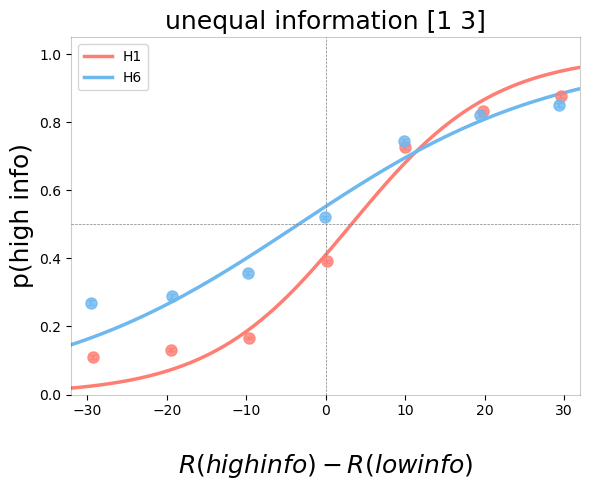

In [79]:
import scipy.stats as stats
plt.figure(figsize=(6, 5))
# Custom colors matching your request
horizons = {1: {'color': "#ff7e73", 'label': 'H1'}, 
            6: {'color': "#6eb8f0", 'label': 'H6'}} 

# Standard research bins
bins = [-35, -25, -15, -5, 5, 15, 25, 35]

for h, config in horizons.items():
    # Filter for the current horizon
    sub = unequal_df[unequal_df['gameLength'] == h].dropna(subset=['dx', 'dy']).copy()
    
    if len(sub) == 0: continue

    # --- PART A: EMPIRICAL DATA (DOTS & BARS) ---
    # Create bins for the x-axis (delta R)
    sub['bin'] = pd.cut(sub['dx'], bins=bins, labels=False, include_lowest=True)
    
    empirical = sub.groupby('bin').agg({
        'dy': ['mean', stats.sem], 
        'dx': 'mean'
    })

    plt.errorbar(
        empirical['dx']['mean'], 
        empirical['dy']['mean'], 
        yerr=empirical['dy']['sem'], 
        fmt='o', 
        color=config['color'],
        capsize=3, 
        markersize=8,
        alpha=0.8
    )

    # --- PART B: MODEL FIT (CURVES) ---
    # Fit parameters A (bonus), B (bias), and sigma (noise) 
    popt, _ = curve_fit(logistic_model, sub['dx'], sub['dy'], p0=[5, 0, 8])
    x_smooth = np.linspace(-32, 32, 100)
    plt.plot(x_smooth, logistic_model(x_smooth, *popt), 
             color=config['color'], label=config['label'], linewidth=2.5)

# 4. Styling
plt.axhline(0.5, color='gray', linewidth=0.5, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.5, linestyle='--')
plt.ylim(0, 1.05)
plt.xlim(-32, 32)
plt.title('unequal information [1 3]', fontsize=18)
plt.xlabel('\n$R(high info) - R(low info)$', fontsize=18)
plt.ylabel('p(high info)', fontsize=18)
plt.xticks([-30, -20, -10, 0, 10, 20, 30])
plt.legend(frameon=True)
ax = plt.gca() # Get current axes
for edge in ['top', 'right', 'bottom', 'left']:
    ax.spines[edge].set_alpha(0.2)
    ax.spines[edge].set_linewidth(0.8) # Thinner lines also feel "softer"
plt.tight_layout()
plt.show()

# choose left

In [52]:
equal_df = df[df['uc'] == 0].copy()

def get_equal_stats(row):
    left_vals = [row[f'r{i}'] for i in range(4) if row[f'c{i}'] == 1]
    right_vals = [row[f'r{i}'] for i in range(4) if row[f'c{i}'] == 0]
    
    delta_r = np.mean(left_vals) - np.mean(right_vals)
    is_left_choice = 1 if row['c4'] == 1 else 0
    return pd.Series([delta_r, is_left_choice], index=['dx', 'dy'])

equal_df[['dx', 'dy']] = equal_df.apply(get_equal_stats, axis=1)



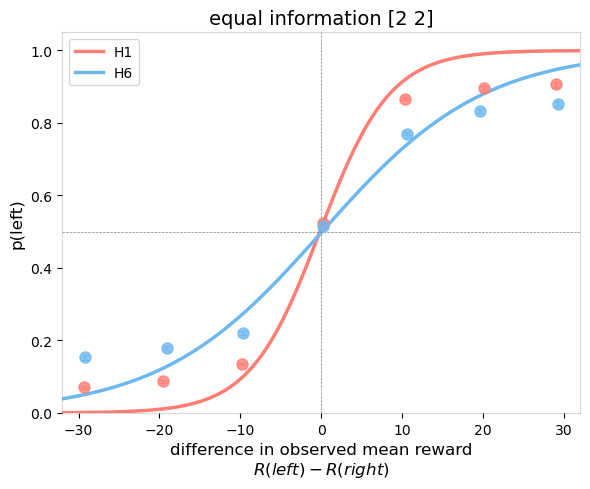

In [ ]:
plt.figure(figsize=(6, 5))
horizons = {1: {'color': "#ff7e73", 'label': 'H1'}, 
            6: {'color': "#6eb8f0", 'label': 'H6'}} 

bins = [-35, -25, -15, -5, 5, 15, 25, 35]

for h, config in horizons.items():
    sub = equal_df[equal_df['gameLength'] == h].dropna(subset=['dx', 'dy']).copy()
    if len(sub) == 0: continue

    # --- Empirical Data ---
    sub['bin'] = pd.cut(sub['dx'], bins=bins, labels=False, include_lowest=True)
    empirical = sub.groupby('bin').agg({'dy': ['mean', stats.sem], 'dx': 'mean'})

    plt.errorbar(empirical['dx']['mean'], empirical['dy']['mean'], 
                 yerr=empirical['dy']['sem'], fmt='o', color=config['color'], 
                 capsize=3, markersize=8, alpha=0.8)

    # --- Model Fit ---
    # In Equal condition, Info Bonus A is typically fixed to 0
    popt, _ = curve_fit(lambda x, B, sigma: logistic_model(x, 0, B, sigma), 
                        sub['dx'], sub['dy'], p0=[0, 8])
    
    x_smooth = np.linspace(-32, 32, 100)
    plt.plot(x_smooth, logistic_model(x_smooth, 0, *popt), 
             color=config['color'], label=config['label'], linewidth=2.5)

# 4. Styling & Softened Boundaries
ax = plt.gca()
plt.axhline(0.5, color='gray', linewidth=0.5, linestyle='--')
plt.axvline(0, color='gray', linewidth=0.5, linestyle='--')

# Soften the spines (boundaries)
for edge in ['top', 'right', 'bottom', 'left']:
    ax.spines[edge].set_alpha(0.3)
    ax.spines[edge].set_color('gray')

plt.ylim(0, 1.05)
plt.xlim(-32, 32)
plt.title('equal information [2 2]', fontsize=14)
plt.xlabel('\n$R(left) - R(right)$', fontsize=12)
plt.ylabel('p(left)', fontsize=12)
plt.legend(frameon=True)
plt.tight_layout()
plt.show()

# param estimation

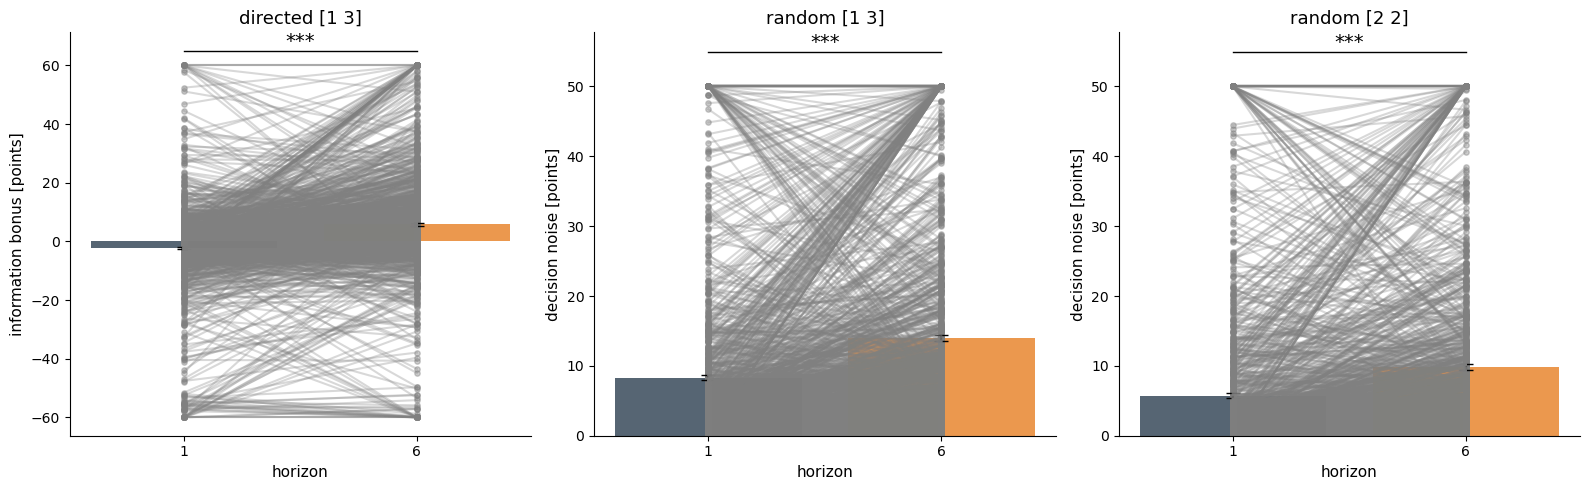

In [ ]:
def fit_subject_parameters(sub_df, condition_type):
    """Fits logistic parameters for a single subject across horizons."""
    params = {}
    for h in [1, 6]:
        h_df = sub_df[sub_df['gameLength'] == h].dropna(subset=['dx', 'dy'])
        if len(h_df) < 5: # Minimum trials for valid fit
            params[h] = [np.nan, np.nan, np.nan]
            continue
            
        try:
            if condition_type == 'unequal':
                # Fit Information Bonus (A), Bias (B), and Noise (sigma)
                popt, _ = curve_fit(logistic_model, h_df['dx'], h_df['dy'], 
                                   p0=[5, 0, 8], bounds=([-60, -20, 0.1], [60, 20, 50]))
                params[h] = popt 
            else:
                # Equal Condition: Fix A=0, fit Bias (B) and Noise (sigma)
                popt, _ = curve_fit(lambda x, B, sigma: logistic_model(x, 0, B, sigma), 
                                   h_df['dx'], h_df['dy'], p0=[0, 8], bounds=([-20, 0.1], [20, 50]))
                params[h] = [0, popt[0], popt[1]] # A is 0
        except:
            params[h] = [np.nan, np.nan, np.nan]
    return params

# 1. Processing and Fitting
subjects = df['subject'].unique()
summary = []

for sub in subjects:
    # Unequal Condition Mapping
    u_sub = unequal_df[unequal_df['subject'] == sub]
    u_p = fit_subject_parameters(u_sub, 'unequal')
    
    # Equal Condition Mapping
    e_sub = equal_df[equal_df['subject'] == sub]
    e_p = fit_subject_parameters(e_sub, 'equal')
    
    summary.append({
        'subject': sub,
        'u_A_h1': u_p[1][0], 'u_sigma_h1': u_p[1][2],
        'u_A_h6': u_p[6][0], 'u_sigma_h6': u_p[6][2],
        'e_sigma_h1': e_p[1][2], 'e_sigma_h6': e_p[6][2]
    })

results_df = pd.DataFrame(summary).dropna()


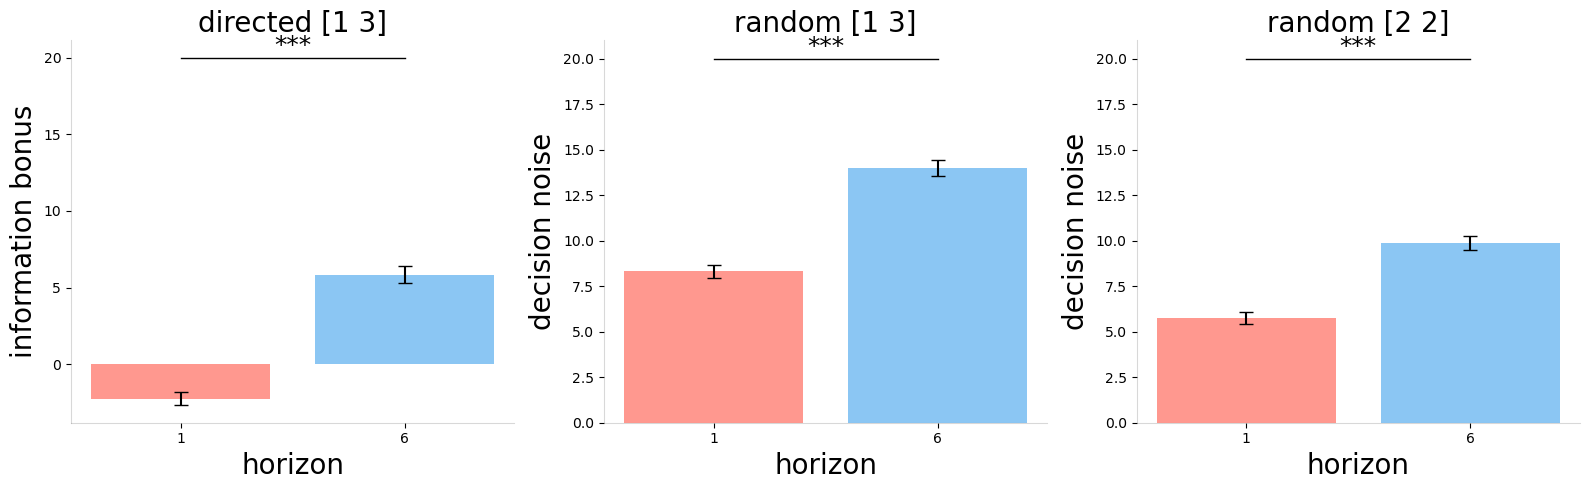

In [77]:

# 2. Plotting (Fig 3C, D, E)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
titles = ['directed [1 3]', 'random [1 3]', 'random [2 2]']
ylabels = ['information bonus', 'decision noise', 'decision noise']
cols = [['u_A_h1', 'u_A_h6'], ['u_sigma_h1', 'u_sigma_h6'], ['e_sigma_h1', 'e_sigma_h6']]
colors = ["#ff7e73", "#6eb8f0"] # Red H6, Blue H1

for i, (param_cols, label) in enumerate(zip(cols, ylabels)):
    ax = axes[i]
    h1_vals, h6_vals = results_df[param_cols[0]], results_df[param_cols[1]]
    
    # Bar Plot (Group Mean)
    ax.bar(['1', '6'], [h1_vals.mean(), h6_vals.mean()], 
           yerr=[h1_vals.sem(), h6_vals.sem()], 
        #    width=0.5,
           color=colors, alpha=0.8, capsize=5)
    
    # # Individual Subject Lines & Dots
    # for _, row in results_df.iterrows():
    #     ax.plot(['1', '6'], [row[param_cols[0]], row[param_cols[1]]], color='gray', alpha=0.3)
    #     ax.scatter(['1', '6'], [row[param_cols[0]], row[param_cols[1]]], color=colors, alpha=0.4, s=15)

    # Statistics (p < 0.001)
    t_stat, p_val = stats.ttest_rel(h1_vals, h6_vals)
    if p_val < 0.001:
        y_max = 20
        ax.plot(['1', '6'], [y_max, y_max], color='black', lw=1)
        ax.text(0.5, y_max, '***', ha='center', va='bottom', fontsize=18)

    for edge in ['top', 'right', 'bottom', 'left']:
            ax.spines[edge].set_alpha(0.3)
            ax.spines[edge].set_color('gray')

    ax.set_title(titles[i], fontsize=20)
    ax.set_ylabel(label, fontsize=20)
    ax.set_xlabel('horizon', fontsize=20)
    ax.spines[['top', 'right']].set_visible(False)

    

plt.tight_layout()
plt.show()